In [251]:
# Import Library 

import numpy as np
import matplotlib.pyplot as plt
import inspect


In [252]:
# Setting for the model

USE_FINITE_DIFFERENCE = True   # If False, use analytical derivative of the function
NOISE_FRAC = 0.00              # Control noise level as fraction of std of derivative (bigger the frac, bigger the noise)
SPARSITY_THRESH = 0.05        # Core idea of SINDy STLS (Sequential Threshold of Least Squares)
np.random.seed(0)             # Generate random num

In [253]:
# Variables in Theta (Library)
library_terms = [
    (lambda x: np.ones_like(x), "1"),     # constant term
    (lambda x: x, "x"),
    (lambda x: x**2, "x^2"),
    (lambda x: x**3, "x^3")
]

Theta = np.column_stack([f(x) for f, _ in library_terms])   # Library containing all the candidate variables
feature_names = [name for _, name in library_terms]


In [254]:
# 1D Trajectory

t = np.linspace(0, 10, 1001)
dt = t[1] - t[0]
x = 2*t**3 + t**2 - 3*t + 4
xdot_true = 6*t**2 + 2*t - 3

In [255]:
# Estimating the derivative 

if USE_FINITE_DIFFERENCE:                         # Use FE method 
    xdot_est = np.gradient(x, dt)             
else:
    xdot_est = xdot_true.copy()                   # The True derivative function 

In [256]:
# Add noise to the data (x-dot)

noise = NOISE_FRAC * np.std(xdot_est) * np.random.randn(xdot_est.size) 
xdot_noisy = xdot_est + noise

In [257]:
# OLS fitting 

w, *_ = np.linalg.lstsq(Theta, xdot_noisy, rcond=None) 

In [258]:
#Applying Sparsity

w_sparse = w.copy()
w_sparse[np.abs(w_sparse) < SPARSITY_THRESH] = 0.0

In [259]:
# Predicted derivative from fitted model

xdot_fit = Theta @ w_sparse

In [260]:
# Print discovered equation

print("Coefficients (before sparsity):", w.round(5))
print("Coefficients (after sparsity) :", w_sparse.round(5))

terms = [
    f"{w_sparse[i]:+.3f}·{feature_names[i]}"
    for i in range(len(w_sparse))
    if abs(w_sparse[i]) >= SPARSITY_THRESH
]
equation = " + ".join(terms)

print("Discovered model: dx/dt ≈", equation)

Coefficients (before sparsity): [ 1.390313e+01  5.872400e-01 -2.900000e-04  0.000000e+00]
Coefficients (after sparsity) : [13.90313  0.58724  0.       0.     ]
Discovered model: dx/dt ≈ +13.903·1 + +0.587·x


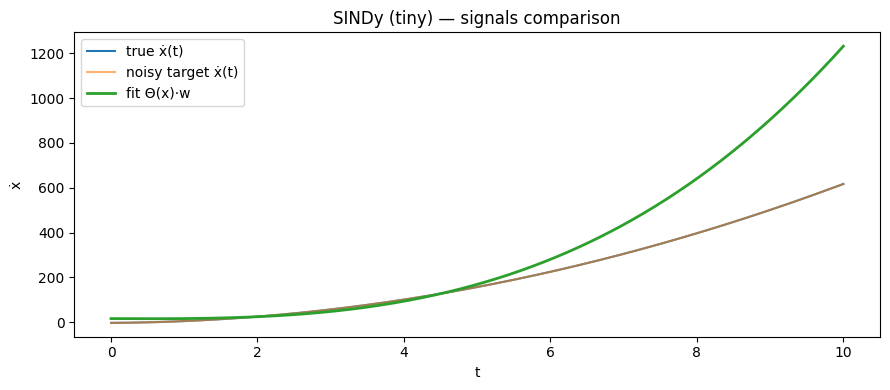

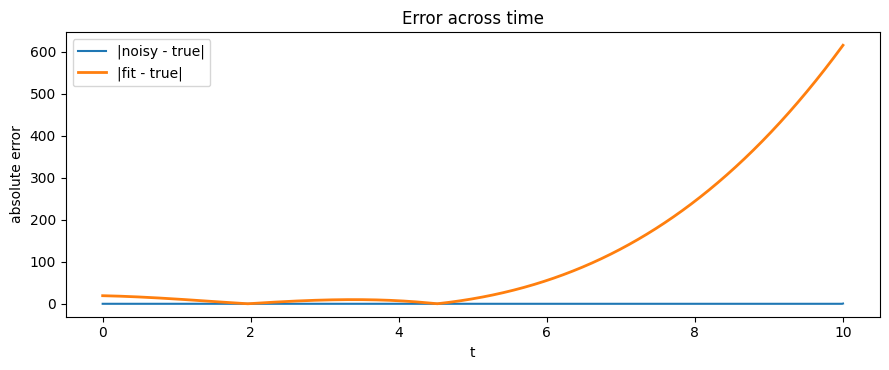

In [261]:
# Visualize the fit and Error 

# Figure 1: The True derivative, Noisy derivative, and the Fitted derivative

plt.figure(figsize=(9, 4))
plt.plot(t, xdot_true, label="true ẋ(t)")
plt.plot(t, xdot_noisy, label="noisy target ẋ(t)", alpha=0.6)
plt.plot(t, xdot_fit, label="fit Θ(x)·w", linewidth=2)
plt.xlabel("t")
plt.ylabel("ẋ")
plt.title("SINDy (tiny) — signals comparison")
plt.legend()
plt.tight_layout()
plt.show()

# Figure 2 Error vs time: |noisy - true| and |fit - true|

err_noisy = np.abs(xdot_noisy - xdot_true)
err_fit = np.abs(xdot_fit - xdot_true)

plt.figure(figsize=(9, 3.8))
plt.plot(t, err_noisy, label="|noisy - true|")
plt.plot(t, err_fit, label="|fit - true|", linewidth=2)
plt.xlabel("t")
plt.ylabel("absolute error")
plt.title("Error across time")
plt.legend()
plt.tight_layout()
plt.show()
